# Visual Transformer with Linformer

Training Visual Transformer on *Dogs vs Cats Data*

* Dogs vs. Cats Redux: Kernels Edition - https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition
* Base Code - https://www.kaggle.com/reukki/pytorch-cnn-tutorial-with-cats-and-dogs/
* Efficient Attention Implementation - https://github.com/lucidrains/vit-pytorch#efficient-attention

In [1]:
#!pip -q install vit_pytorch linformer pandas sklearn scikit-learn ipywidgets

## Import Libraries

In [2]:
from __future__ import print_function

import glob
from itertools import chain
import os
import random
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from linformer import Linformer
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm import tqdm

from vit_pytorch.efficient import ViT
from convert_pilimage_to_onehot import convert_pilimage_to_onehot


In [3]:
print(f"Torch: {torch.__version__}")

Torch: 2.0.1


In [4]:
# Training settings
batch_size = 64
epochs = 120
lr = 3e-5
gamma = 0.7
seed = 42

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [6]:
#device = 'cpu'
device = 'mps'
#device = 'cuda'

## Load Data

In [7]:
os.makedirs('data', exist_ok=True)

In [8]:
with zipfile.ZipFile('tasks.zip') as tasks_zip:
    tasks_zip.extractall('data')

In [9]:
train_list = glob.glob('data/tasks/**/train/*.png', recursive=True)
test_list = glob.glob('data/tasks/**/test/*.png', recursive=True)

In [10]:
print(f"Train Data: {len(train_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 10080
Test Data: 1372


In [11]:
labels = [path.split('/')[-1].split('.')[0] for path in train_list]

## Random Plots

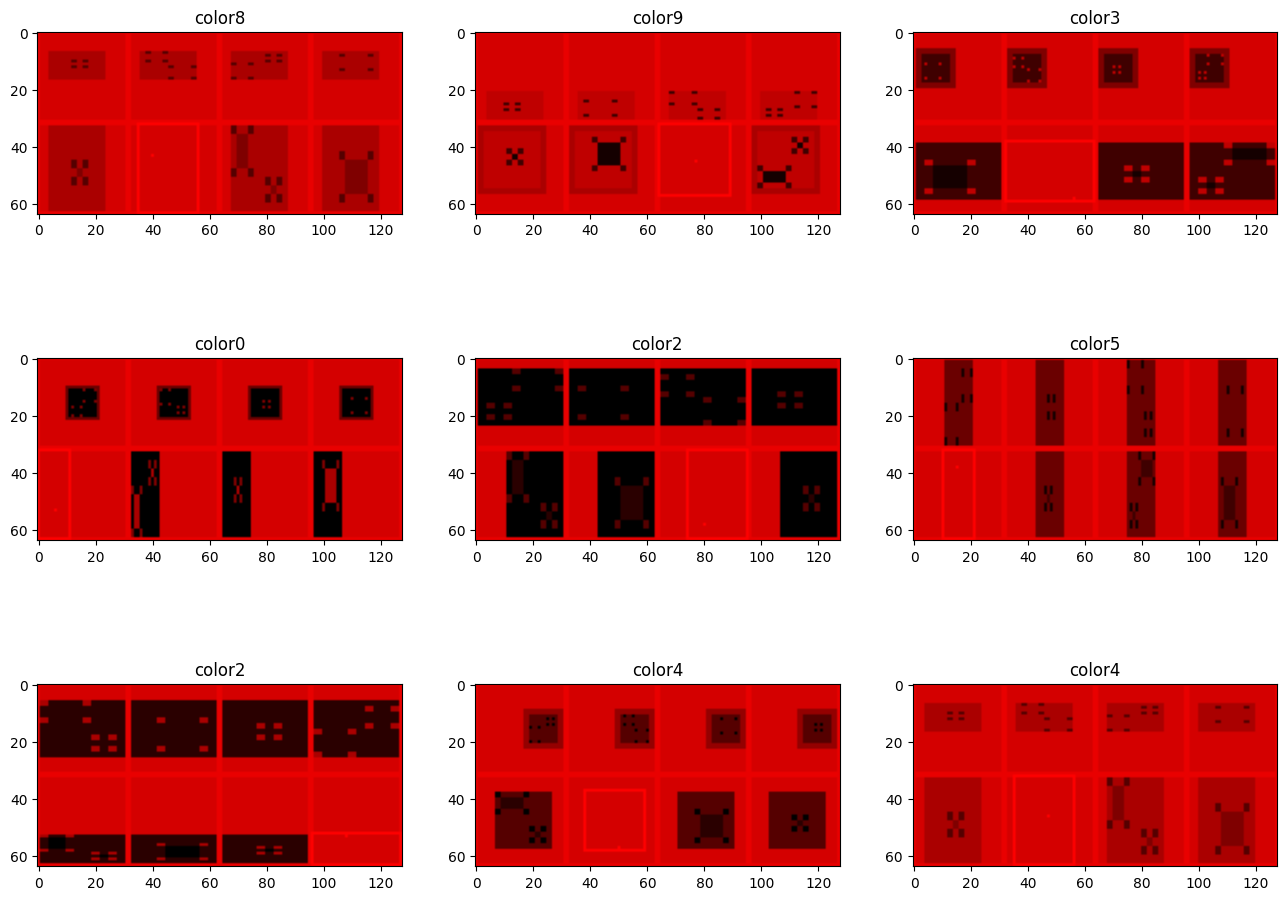

In [12]:
random_idx = np.random.randint(1, len(train_list), size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))

for idx, ax in enumerate(axes.ravel()):
    img = Image.open(train_list[idx])
    ax.set_title(labels[idx])
    ax.imshow(img)


## Split

In [13]:
train_list, valid_list = train_test_split(train_list, 
                                          test_size=0.2,
                                          stratify=labels,
                                          random_state=seed)

In [14]:
print(f"Train Data: {len(train_list)}")
print(f"Validation Data: {len(valid_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 8064
Validation Data: 2016
Test Data: 1372


## Image Augmentation

In [15]:
train_transforms = transforms.Compose(
    [
        #transforms.Resize(224),
        transforms.Resize((224, 224)),
        #transforms.RandomResizedCrop(224),
        #transforms.RandomHorizontalFlip(),
        #transforms.ToTensor(),
    ]
)

val_transforms = transforms.Compose(
    [
        #transforms.Resize(224),
        transforms.Resize((224, 224)),
        #transforms.Resize(256),
        #transforms.CenterCrop(224),
        #transforms.ToTensor(),
    ]
)


test_transforms = transforms.Compose(
    [
        #transforms.Resize(224),
        transforms.Resize((224, 224)),
        #transforms.Resize(256),
        #transforms.CenterCrop(224),
        #transforms.ToTensor(),
    ]
)


## Load Datasets

In [16]:
class CatsDogsDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        #img_transformed = self.transform(img)
        img_transformed1 = self.transform(img)
        img_transformed2 = convert_pilimage_to_onehot(img_transformed1)
        img_transformed3 = img_transformed2.transpose(2, 0, 1)
        img_transformed = torch.from_numpy(img_transformed3.astype(np.float32))
        #print("shape a:", img_transformed.shape)

        raw_label = img_path.split("/")[-1].split(".")[0]
        label = 0
        if raw_label == "color0":
            label = 0
        if raw_label == "color1":
            label = 1
        if raw_label == "color2":
            label = 2
        if raw_label == "color3":
            label = 3
        if raw_label == "color4":
            label = 4
        if raw_label == "color5":
            label = 5
        if raw_label == "color6":
            label = 6
        if raw_label == "color7":
            label = 7
        if raw_label == "color8":
            label = 8
        if raw_label == "color9":
            label = 9
            
        return img_transformed, label


In [17]:
train_data = CatsDogsDataset(train_list, transform=train_transforms)
valid_data = CatsDogsDataset(valid_list, transform=test_transforms)
test_data = CatsDogsDataset(test_list, transform=test_transforms)

In [18]:
train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)

In [19]:
print(len(train_data), len(train_loader))

8064 126


In [20]:
print(len(valid_data), len(valid_loader))

2016 32


## Efficient Attention

### Linformer

In [21]:
efficient_transformer = Linformer(
    dim=128,
    seq_len=49+1,  # 7x7 patches + 1 cls-token
    depth=12,
    heads=8,
    k=64
)

### Visual Transformer

In [22]:
model = ViT(
    dim=128,
    image_size=224,
    patch_size=32,
    num_classes=10,
    transformer=efficient_transformer,
    channels=13,
).to(device)

### Training

In [23]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [24]:
checkpoint = torch.load('checkpoint2.pt')
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])
epoch = checkpoint['epoch']

In [25]:
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:43<00:00,  2.88it/s]


Epoch : 1 - loss : 1.0040 - acc: 0.6760 - val_loss : 0.8468 - val_acc: 0.6948



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:43<00:00,  2.87it/s]


Epoch : 2 - loss : 0.8612 - acc: 0.6920 - val_loss : 0.8082 - val_acc: 0.7080



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:41<00:00,  3.05it/s]


Epoch : 3 - loss : 0.8468 - acc: 0.6932 - val_loss : 0.8147 - val_acc: 0.7095



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:42<00:00,  2.97it/s]


Epoch : 4 - loss : 0.8395 - acc: 0.6923 - val_loss : 0.8035 - val_acc: 0.7026



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:41<00:00,  3.06it/s]


Epoch : 5 - loss : 0.8385 - acc: 0.6939 - val_loss : 0.8055 - val_acc: 0.7104



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:41<00:00,  3.04it/s]


Epoch : 6 - loss : 0.8367 - acc: 0.6923 - val_loss : 0.8012 - val_acc: 0.7070



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:40<00:00,  3.07it/s]


Epoch : 7 - loss : 0.8344 - acc: 0.6956 - val_loss : 0.7982 - val_acc: 0.7109



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:41<00:00,  3.00it/s]


Epoch : 8 - loss : 0.8326 - acc: 0.6932 - val_loss : 0.7961 - val_acc: 0.7007



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:39<00:00,  3.17it/s]


Epoch : 9 - loss : 0.8338 - acc: 0.6953 - val_loss : 0.8077 - val_acc: 0.7017



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:39<00:00,  3.17it/s]


Epoch : 10 - loss : 0.8318 - acc: 0.6973 - val_loss : 0.8012 - val_acc: 0.7104



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:39<00:00,  3.18it/s]


Epoch : 11 - loss : 0.8326 - acc: 0.6957 - val_loss : 0.8012 - val_acc: 0.7021



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:39<00:00,  3.19it/s]


Epoch : 12 - loss : 0.8334 - acc: 0.6944 - val_loss : 0.8037 - val_acc: 0.7075



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:39<00:00,  3.18it/s]


Epoch : 13 - loss : 0.8320 - acc: 0.6958 - val_loss : 0.8009 - val_acc: 0.7104



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:39<00:00,  3.17it/s]


Epoch : 14 - loss : 0.8295 - acc: 0.6946 - val_loss : 0.7983 - val_acc: 0.7109



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:39<00:00,  3.17it/s]


Epoch : 15 - loss : 0.8287 - acc: 0.6958 - val_loss : 0.8062 - val_acc: 0.7090



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:39<00:00,  3.18it/s]


Epoch : 16 - loss : 0.8331 - acc: 0.6928 - val_loss : 0.8053 - val_acc: 0.7095



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:39<00:00,  3.19it/s]


Epoch : 17 - loss : 0.8288 - acc: 0.6966 - val_loss : 0.7967 - val_acc: 0.7061



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:39<00:00,  3.17it/s]


Epoch : 18 - loss : 0.8292 - acc: 0.6964 - val_loss : 0.8005 - val_acc: 0.7051



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:39<00:00,  3.15it/s]


Epoch : 19 - loss : 0.8292 - acc: 0.6932 - val_loss : 0.8022 - val_acc: 0.7061



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:39<00:00,  3.17it/s]


Epoch : 20 - loss : 0.8290 - acc: 0.6931 - val_loss : 0.7996 - val_acc: 0.7080



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:39<00:00,  3.17it/s]


Epoch : 21 - loss : 0.8292 - acc: 0.6959 - val_loss : 0.7883 - val_acc: 0.7109



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:40<00:00,  3.14it/s]


Epoch : 22 - loss : 0.8288 - acc: 0.6953 - val_loss : 0.7949 - val_acc: 0.7041



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:40<00:00,  3.14it/s]


Epoch : 23 - loss : 0.8271 - acc: 0.6951 - val_loss : 0.8024 - val_acc: 0.7104



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:39<00:00,  3.15it/s]


Epoch : 24 - loss : 0.8287 - acc: 0.6970 - val_loss : 0.7987 - val_acc: 0.7070



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:39<00:00,  3.15it/s]


Epoch : 25 - loss : 0.8271 - acc: 0.6966 - val_loss : 0.8079 - val_acc: 0.7061



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:40<00:00,  3.14it/s]


Epoch : 26 - loss : 0.8275 - acc: 0.6980 - val_loss : 0.7921 - val_acc: 0.7061



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:39<00:00,  3.15it/s]


Epoch : 27 - loss : 0.8272 - acc: 0.6951 - val_loss : 0.7990 - val_acc: 0.6934



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:39<00:00,  3.15it/s]


Epoch : 28 - loss : 0.8277 - acc: 0.6958 - val_loss : 0.8109 - val_acc: 0.7075



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:39<00:00,  3.15it/s]


Epoch : 29 - loss : 0.8255 - acc: 0.6964 - val_loss : 0.7968 - val_acc: 0.6958



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:40<00:00,  3.15it/s]


Epoch : 30 - loss : 0.8289 - acc: 0.6961 - val_loss : 0.7926 - val_acc: 0.7104



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:40<00:00,  3.14it/s]


Epoch : 31 - loss : 0.8259 - acc: 0.6975 - val_loss : 0.7956 - val_acc: 0.7109



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:39<00:00,  3.16it/s]


Epoch : 32 - loss : 0.8271 - acc: 0.6966 - val_loss : 0.7892 - val_acc: 0.7104



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:39<00:00,  3.17it/s]


Epoch : 33 - loss : 0.8268 - acc: 0.6964 - val_loss : 0.8019 - val_acc: 0.7085



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:39<00:00,  3.17it/s]


Epoch : 34 - loss : 0.8258 - acc: 0.6978 - val_loss : 0.7980 - val_acc: 0.7114



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:40<00:00,  3.14it/s]


Epoch : 35 - loss : 0.8247 - acc: 0.6979 - val_loss : 0.7985 - val_acc: 0.7104



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:40<00:00,  3.15it/s]


Epoch : 36 - loss : 0.8271 - acc: 0.6957 - val_loss : 0.7922 - val_acc: 0.7041



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:40<00:00,  3.13it/s]


Epoch : 37 - loss : 0.8269 - acc: 0.6949 - val_loss : 0.7975 - val_acc: 0.7051



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:39<00:00,  3.16it/s]


Epoch : 38 - loss : 0.8268 - acc: 0.6959 - val_loss : 0.7996 - val_acc: 0.7065



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:39<00:00,  3.17it/s]


Epoch : 39 - loss : 0.8281 - acc: 0.6979 - val_loss : 0.7990 - val_acc: 0.7095



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:39<00:00,  3.17it/s]


Epoch : 40 - loss : 0.8255 - acc: 0.6954 - val_loss : 0.7901 - val_acc: 0.7119



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:39<00:00,  3.17it/s]


Epoch : 41 - loss : 0.8270 - acc: 0.6982 - val_loss : 0.8062 - val_acc: 0.7046



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:39<00:00,  3.17it/s]


Epoch : 42 - loss : 0.8244 - acc: 0.6959 - val_loss : 0.7958 - val_acc: 0.7114



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:39<00:00,  3.17it/s]


Epoch : 43 - loss : 0.8252 - acc: 0.6959 - val_loss : 0.7893 - val_acc: 0.7061



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:39<00:00,  3.17it/s]


Epoch : 44 - loss : 0.8258 - acc: 0.6969 - val_loss : 0.8044 - val_acc: 0.7061



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:39<00:00,  3.17it/s]


Epoch : 45 - loss : 0.8248 - acc: 0.6941 - val_loss : 0.7905 - val_acc: 0.7075



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:39<00:00,  3.16it/s]


Epoch : 46 - loss : 0.8256 - acc: 0.6980 - val_loss : 0.7994 - val_acc: 0.7100



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:39<00:00,  3.17it/s]


Epoch : 47 - loss : 0.8242 - acc: 0.6973 - val_loss : 0.7953 - val_acc: 0.7041



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:39<00:00,  3.18it/s]


Epoch : 48 - loss : 0.8259 - acc: 0.6952 - val_loss : 0.7913 - val_acc: 0.7100



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:39<00:00,  3.16it/s]


Epoch : 49 - loss : 0.8232 - acc: 0.6952 - val_loss : 0.7912 - val_acc: 0.7065



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:39<00:00,  3.17it/s]


Epoch : 50 - loss : 0.8246 - acc: 0.6962 - val_loss : 0.7910 - val_acc: 0.7124



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:39<00:00,  3.17it/s]


Epoch : 51 - loss : 0.8250 - acc: 0.6975 - val_loss : 0.7946 - val_acc: 0.7100



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:39<00:00,  3.17it/s]


Epoch : 52 - loss : 0.8252 - acc: 0.6977 - val_loss : 0.7934 - val_acc: 0.7061



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:39<00:00,  3.19it/s]


Epoch : 53 - loss : 0.8215 - acc: 0.6961 - val_loss : 0.7904 - val_acc: 0.7104



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:39<00:00,  3.17it/s]


Epoch : 54 - loss : 0.8251 - acc: 0.6962 - val_loss : 0.7890 - val_acc: 0.7051



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:39<00:00,  3.17it/s]


Epoch : 55 - loss : 0.8222 - acc: 0.6938 - val_loss : 0.7958 - val_acc: 0.7070



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:39<00:00,  3.16it/s]


Epoch : 56 - loss : 0.8243 - acc: 0.6970 - val_loss : 0.7951 - val_acc: 0.7056



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:39<00:00,  3.17it/s]


Epoch : 57 - loss : 0.8244 - acc: 0.6928 - val_loss : 0.7909 - val_acc: 0.7109



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:39<00:00,  3.18it/s]


Epoch : 58 - loss : 0.8232 - acc: 0.6948 - val_loss : 0.7903 - val_acc: 0.7070



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:39<00:00,  3.16it/s]


Epoch : 59 - loss : 0.8237 - acc: 0.6953 - val_loss : 0.7961 - val_acc: 0.7109



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:39<00:00,  3.17it/s]


Epoch : 60 - loss : 0.8240 - acc: 0.6978 - val_loss : 0.7950 - val_acc: 0.7134



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:39<00:00,  3.16it/s]


Epoch : 61 - loss : 0.8231 - acc: 0.6952 - val_loss : 0.7950 - val_acc: 0.7080



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:39<00:00,  3.16it/s]


Epoch : 62 - loss : 0.8219 - acc: 0.6963 - val_loss : 0.7866 - val_acc: 0.7104



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:39<00:00,  3.16it/s]


Epoch : 63 - loss : 0.8242 - acc: 0.6987 - val_loss : 0.7892 - val_acc: 0.7095



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:39<00:00,  3.16it/s]


Epoch : 64 - loss : 0.8241 - acc: 0.6969 - val_loss : 0.8033 - val_acc: 0.7075



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:39<00:00,  3.16it/s]


Epoch : 65 - loss : 0.8243 - acc: 0.6978 - val_loss : 0.7944 - val_acc: 0.7095



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:39<00:00,  3.15it/s]


Epoch : 66 - loss : 0.8225 - acc: 0.6968 - val_loss : 0.7920 - val_acc: 0.7026



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:40<00:00,  3.14it/s]


Epoch : 67 - loss : 0.8227 - acc: 0.6974 - val_loss : 0.7877 - val_acc: 0.7114



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:40<00:00,  3.13it/s]


Epoch : 68 - loss : 0.8210 - acc: 0.6961 - val_loss : 0.8029 - val_acc: 0.7095



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:40<00:00,  3.13it/s]


Epoch : 69 - loss : 0.8234 - acc: 0.6979 - val_loss : 0.7943 - val_acc: 0.7061



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:39<00:00,  3.15it/s]


Epoch : 70 - loss : 0.8224 - acc: 0.6947 - val_loss : 0.7978 - val_acc: 0.7095



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:40<00:00,  3.15it/s]


Epoch : 71 - loss : 0.8218 - acc: 0.6967 - val_loss : 0.7983 - val_acc: 0.7085



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:39<00:00,  3.16it/s]


Epoch : 72 - loss : 0.8217 - acc: 0.6990 - val_loss : 0.7999 - val_acc: 0.7095



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:39<00:00,  3.16it/s]


Epoch : 73 - loss : 0.8231 - acc: 0.6969 - val_loss : 0.7904 - val_acc: 0.7070



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:39<00:00,  3.16it/s]


Epoch : 74 - loss : 0.8231 - acc: 0.6972 - val_loss : 0.7989 - val_acc: 0.7065



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:39<00:00,  3.15it/s]


Epoch : 75 - loss : 0.8228 - acc: 0.6977 - val_loss : 0.7957 - val_acc: 0.7051



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:39<00:00,  3.17it/s]


Epoch : 76 - loss : 0.8210 - acc: 0.6978 - val_loss : 0.7944 - val_acc: 0.7095



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:40<00:00,  3.14it/s]


Epoch : 77 - loss : 0.8220 - acc: 0.6979 - val_loss : 0.7860 - val_acc: 0.7114



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:39<00:00,  3.17it/s]


Epoch : 78 - loss : 0.8203 - acc: 0.6963 - val_loss : 0.8022 - val_acc: 0.7085



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:40<00:00,  3.15it/s]


Epoch : 79 - loss : 0.8209 - acc: 0.6966 - val_loss : 0.7911 - val_acc: 0.7070



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:39<00:00,  3.16it/s]


Epoch : 80 - loss : 0.8214 - acc: 0.6978 - val_loss : 0.7890 - val_acc: 0.7090



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:39<00:00,  3.17it/s]


Epoch : 81 - loss : 0.8213 - acc: 0.6963 - val_loss : 0.7943 - val_acc: 0.7085



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:39<00:00,  3.15it/s]


Epoch : 82 - loss : 0.8193 - acc: 0.6975 - val_loss : 0.7893 - val_acc: 0.7109



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:40<00:00,  3.15it/s]


Epoch : 83 - loss : 0.8224 - acc: 0.6980 - val_loss : 0.7913 - val_acc: 0.7100



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:39<00:00,  3.15it/s]


Epoch : 84 - loss : 0.8202 - acc: 0.6973 - val_loss : 0.7864 - val_acc: 0.7134



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:39<00:00,  3.16it/s]


Epoch : 85 - loss : 0.8212 - acc: 0.6959 - val_loss : 0.8013 - val_acc: 0.7051



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:40<00:00,  3.15it/s]


Epoch : 86 - loss : 0.8212 - acc: 0.6982 - val_loss : 0.7875 - val_acc: 0.7134



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:39<00:00,  3.16it/s]


Epoch : 87 - loss : 0.8222 - acc: 0.6956 - val_loss : 0.7898 - val_acc: 0.7080



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:39<00:00,  3.16it/s]


Epoch : 88 - loss : 0.8219 - acc: 0.6972 - val_loss : 0.7934 - val_acc: 0.7114



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:40<00:00,  3.14it/s]


Epoch : 89 - loss : 0.8208 - acc: 0.6980 - val_loss : 0.7987 - val_acc: 0.7104



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:40<00:00,  3.14it/s]


Epoch : 90 - loss : 0.8213 - acc: 0.6958 - val_loss : 0.7887 - val_acc: 0.7036



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:40<00:00,  3.15it/s]


Epoch : 91 - loss : 0.8208 - acc: 0.6966 - val_loss : 0.7952 - val_acc: 0.7085



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:40<00:00,  3.15it/s]


Epoch : 92 - loss : 0.8199 - acc: 0.6959 - val_loss : 0.7922 - val_acc: 0.7075



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:40<00:00,  3.14it/s]


Epoch : 93 - loss : 0.8216 - acc: 0.6944 - val_loss : 0.7934 - val_acc: 0.7051



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:39<00:00,  3.16it/s]


Epoch : 94 - loss : 0.8206 - acc: 0.6977 - val_loss : 0.7926 - val_acc: 0.7036



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:40<00:00,  3.15it/s]


Epoch : 95 - loss : 0.8205 - acc: 0.6979 - val_loss : 0.7934 - val_acc: 0.7085



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:40<00:00,  3.12it/s]


Epoch : 96 - loss : 0.8206 - acc: 0.6973 - val_loss : 0.7978 - val_acc: 0.7046



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:40<00:00,  3.14it/s]


Epoch : 97 - loss : 0.8208 - acc: 0.6957 - val_loss : 0.7843 - val_acc: 0.7104



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:40<00:00,  3.12it/s]


Epoch : 98 - loss : 0.8201 - acc: 0.6968 - val_loss : 0.7978 - val_acc: 0.7061



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:40<00:00,  3.12it/s]


Epoch : 99 - loss : 0.8204 - acc: 0.6978 - val_loss : 0.7926 - val_acc: 0.7104



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:40<00:00,  3.11it/s]


Epoch : 100 - loss : 0.8211 - acc: 0.6980 - val_loss : 0.7898 - val_acc: 0.7075



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:40<00:00,  3.13it/s]


Epoch : 101 - loss : 0.8200 - acc: 0.6966 - val_loss : 0.7905 - val_acc: 0.7104



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:40<00:00,  3.14it/s]


Epoch : 102 - loss : 0.8195 - acc: 0.6978 - val_loss : 0.7926 - val_acc: 0.7090



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:40<00:00,  3.14it/s]


Epoch : 103 - loss : 0.8200 - acc: 0.6977 - val_loss : 0.7955 - val_acc: 0.7100



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:40<00:00,  3.14it/s]


Epoch : 104 - loss : 0.8204 - acc: 0.6969 - val_loss : 0.7900 - val_acc: 0.7095



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:40<00:00,  3.14it/s]


Epoch : 105 - loss : 0.8202 - acc: 0.6970 - val_loss : 0.7872 - val_acc: 0.7124



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:40<00:00,  3.15it/s]


Epoch : 106 - loss : 0.8200 - acc: 0.6985 - val_loss : 0.7933 - val_acc: 0.7075



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:40<00:00,  3.13it/s]


Epoch : 107 - loss : 0.8195 - acc: 0.6972 - val_loss : 0.7894 - val_acc: 0.7090



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:40<00:00,  3.15it/s]


Epoch : 108 - loss : 0.8193 - acc: 0.6982 - val_loss : 0.7897 - val_acc: 0.7109



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:40<00:00,  3.13it/s]


Epoch : 109 - loss : 0.8204 - acc: 0.6967 - val_loss : 0.7895 - val_acc: 0.7061



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:40<00:00,  3.14it/s]


Epoch : 110 - loss : 0.8195 - acc: 0.6987 - val_loss : 0.7909 - val_acc: 0.7041



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:40<00:00,  3.14it/s]


Epoch : 111 - loss : 0.8200 - acc: 0.6973 - val_loss : 0.7964 - val_acc: 0.7041



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:40<00:00,  3.13it/s]


Epoch : 112 - loss : 0.8202 - acc: 0.6956 - val_loss : 0.7901 - val_acc: 0.7109



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:40<00:00,  3.14it/s]


Epoch : 113 - loss : 0.8180 - acc: 0.6980 - val_loss : 0.7930 - val_acc: 0.7031



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:40<00:00,  3.13it/s]


Epoch : 114 - loss : 0.8195 - acc: 0.6958 - val_loss : 0.7828 - val_acc: 0.7100



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:40<00:00,  3.14it/s]


Epoch : 115 - loss : 0.8164 - acc: 0.6973 - val_loss : 0.7897 - val_acc: 0.7085



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:39<00:00,  3.17it/s]


Epoch : 116 - loss : 0.8190 - acc: 0.6979 - val_loss : 0.7866 - val_acc: 0.7109



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:39<00:00,  3.17it/s]


Epoch : 117 - loss : 0.8175 - acc: 0.6982 - val_loss : 0.7897 - val_acc: 0.7109



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:39<00:00,  3.16it/s]


Epoch : 118 - loss : 0.8183 - acc: 0.6970 - val_loss : 0.7954 - val_acc: 0.7046



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:39<00:00,  3.15it/s]


Epoch : 119 - loss : 0.8180 - acc: 0.6959 - val_loss : 0.7950 - val_acc: 0.7109



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:39<00:00,  3.15it/s]


Epoch : 120 - loss : 0.8180 - acc: 0.6982 - val_loss : 0.7956 - val_acc: 0.7002



In [41]:
# Print model's state_dict
#print("Model's state_dict:")
#for param_tensor in model.state_dict():
#    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

In [42]:
#print("Optimizer's state_dict:")
#for var_name in optimizer.state_dict():
#    print(var_name, "\t", optimizer.state_dict()[var_name])

In [26]:
state = {
    'epoch': epoch,
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict(),
}
torch.save(state, 'checkpoint2.pt')

In [27]:
import arc_json_model as ajm
from visualize import ajm_image_show
import export_task_to_image as etti
from pil_image_from_pixels import pil_image_from_pixels_with_red_palette
from simple_image import image_new, set_pixel, draw_rect, draw_box

ajm.Image.show = ajm_image_show

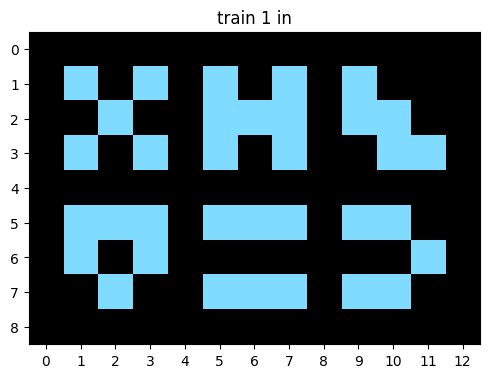

In [70]:
filename = 'testdata/1c0d0a4b.json'
#filename = 'testdata/c3202e5a.json'
#filename = 'testdata/0b148d64.json'
#filename = 'testdata/95a58926.json'
#filename = 'testdata/a59b95c0.json'
#filename = 'testdata/0520fde7.json'
#filename = 'testdata/e98196ab.json'
#filename = 'testdata/23581191.json'
#filename = 'testdata/281123b4.json'
#filename = 'testdata/3428a4f5.json'
#filename = 'testdata/48131b3c.json'
#filename = 'testdata/af902bf9.json'
#filename = 'testdata/cf98881b.json'
#filename = 'testdata/f2829549.json'
#filename = 'testdata/be94b721.json'
#filename = 'testdata/6773b310.json'
task = ajm.Task.load(filename)
image = task.pairs[1].input
image.show()

output size:  13 5


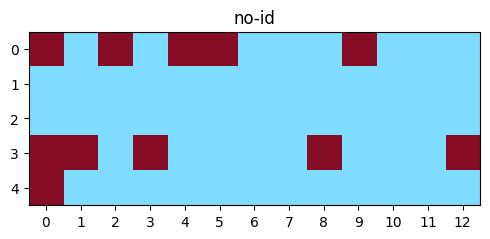

In [71]:
exporter = etti.ExportTaskToImage(task)
pair = task.pairs[0]
output_image_shape = pair.output.pixels.shape
width = output_image_shape[1]
height = output_image_shape[0]
print("output size: ", width, height)
predicted_pixels = image_new(width, height, 255)
for y in range(height):
    for x in range(width):
        pixels = exporter.image_with_mark(0, x, y)
        pil_image = pil_image_from_pixels_with_red_palette(pixels)

        img_transformed1 = test_transforms(pil_image)
        img_transformed2 = convert_pilimage_to_onehot(img_transformed1)
        img_transformed3 = img_transformed2.transpose(2, 0, 1)
        tensor = torch.from_numpy(img_transformed3.astype(np.float32))
        
        #tensor = test_transforms(pil_image)
        tensor = tensor[None, :]
        #if x == 0 and y == 0:
            #pil_image.show()
        #if x == 2 and y == 2:
            #pil_image.show()
        #if x == 3 and y == 3:
            #pil_image.show()
            #print(tensor.shape)

        data = tensor.to(device)
        output = model(data)
        #print(output)
        output_tensor = output.cpu().detach()
        #print(output_tensor)
        output_value = output_tensor.argmax(dim=1)
        #output_value = output_tensor.argmax(dim=None)
        #print(output_value)
        #result_pixels
        set_pixel(predicted_pixels, x, y, output_value)

predicted_image = ajm.Image(predicted_pixels, 'no-id')
predicted_image.show()

In [125]:
class SingleImageDataset(Dataset):
    def __init__(self, single_image: Image, transform=None):
        self.single_image = single_image
        self.transform = transform

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        image = self.single_image.copy()
        if self.transform:
            image = self.transform(image)
        label = 42
        return image, label

output size:  4 4
x, y 0 0
tensor([[ 0.1438,  0.4753,  0.2801, -0.0504,  0.2638, -0.3030, -0.0329, -0.4715,
          0.4869,  0.6095]])
x, y 1 0
tensor([[ 0.1438,  0.4753,  0.2801, -0.0504,  0.2638, -0.3030, -0.0329, -0.4715,
          0.4869,  0.6095]])
x, y 2 0
tensor([[ 0.1438,  0.4753,  0.2801, -0.0504,  0.2638, -0.3030, -0.0329, -0.4715,
          0.4869,  0.6095]])
x, y 3 0
tensor([[ 0.1438,  0.4753,  0.2801, -0.0504,  0.2638, -0.3030, -0.0329, -0.4715,
          0.4869,  0.6095]])
x, y 0 1
tensor([[ 0.1438,  0.4753,  0.2801, -0.0504,  0.2638, -0.3030, -0.0329, -0.4715,
          0.4869,  0.6095]])
x, y 1 1
tensor([[ 0.1438,  0.4753,  0.2801, -0.0504,  0.2638, -0.3030, -0.0329, -0.4715,
          0.4869,  0.6095]])
x, y 2 1
tensor([[ 0.1438,  0.4753,  0.2801, -0.0504,  0.2638, -0.3030, -0.0329, -0.4715,
          0.4869,  0.6095]])
x, y 3 1
tensor([[ 0.1438,  0.4753,  0.2801, -0.0504,  0.2638, -0.3030, -0.0329, -0.4715,
          0.4869,  0.6095]])
x, y 0 2
tensor([[ 0.1438,  0.

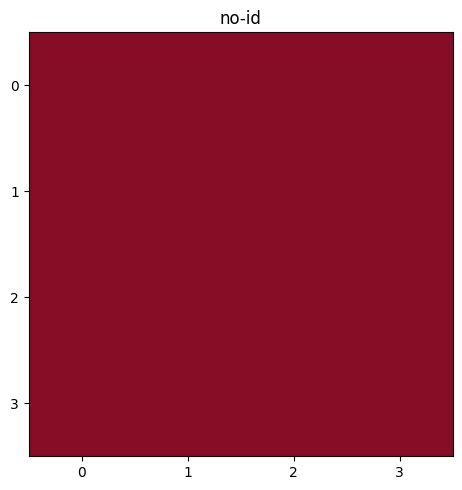

In [131]:

exporter = etti.ExportTaskToImage(task)
pair = task.pairs[0]
output_image_shape = pair.output.pixels.shape
width = output_image_shape[1]
height = output_image_shape[0]
print("output size: ", width, height)
predicted_pixels = image_new(width, height, 255)
for y in range(height):
    for x in range(width):
        print("x, y", x, y)
        pixels = exporter.image_with_mark(0, x, y)
        pil_image = pil_image_from_pixels_with_red_palette(pixels)
        
        my_data = SingleImageDataset(pil_image, transform=test_transforms)
        my_loader = DataLoader(dataset = my_data, batch_size=batch_size, shuffle=True)
        for data, label in my_loader:
            #for data, label in tqdm(my_loader):
            #print(data.shape)
            data = data.to(device)

            output = model(data)
            #print(output)
            output_tensor = output.cpu().detach()
            print(output_tensor)
            output_value = output_tensor.argmax(dim=1)
            #print(output_value)
            #result_pixels
            set_pixel(predicted_pixels, x, y, output_value)

predicted_image = ajm.Image(predicted_pixels, 'no-id')
predicted_image.show()